In [ ]:
%load_ext autoreload
%autoreload 2
import os.path

path = ''
if not os.path.isfile('001_Data_retrieve.ipynb'):
    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/TRABAJO/Data Science/ITBA-DeepLearning/Notebooks/TP-FINAL/bioinformatics_final_project/'
    !pip install rdkit-pypi
    !pip install git+https://github.com/EBjerrum/molvecgen

    #auth.authenticate_user()
    #gauth = GoogleAuth()
    #gauth.credentials = GoogleCredentials.get_application_default()
    #drive = GoogleDrive(gauth)
    #downloaded = drive.CreateFile({'id':'10fMCM9wnmjlyGwiyNzpfPROExiq8ukKk'})
    #downloaded.GetContentFile('dataaug.py')
    #downloaded = drive.CreateFile({'id':'1jPB1HDpGN5zFRuhqN6b9RLMuuUQy0UoB'})
    #downloaded.GetContentFile('datagen.py')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
  Cloning https://github.com/EBjerrum/molvecgen to /tmp/pip-req-build-2q6ppjwa
  Running command git clone -q https://github.com/EBjerrum/molvecgen /tmp/pip-req-build-2q6ppjwa


In [ ]:
#!wget https://raw.githubusercontent.com/EBjerrum/SMILES-enumeration/master/SmilesEnumerator.py

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#from datagen import smiles_dict, smiles_to_seq
#from dataaug import SmilesEnumerator, SmilesIterator
from molvecgen import SmilesVectorizer,SmilesGenerator
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole


from tensorflow.keras import Sequential,regularizers, Model
from tensorflow.keras.layers import InputLayer,LSTM, Dense, Embedding, Bidirectional, Dropout, Activation, BatchNormalization, Conv1D, MaxPool1D, Reshape
from tensorflow.keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D, Flatten, Input, Concatenate,RepeatVector,TimeDistributed,Multiply,Lambda
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.activations import softmax



import datetime

In [ ]:
#Mertrica del Problema
def R2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

def R2_numpy(y_true, y_pred):
    SS_res =  np.sum(np.square( y_true-y_pred ))
    SS_tot = np.sum(np.square( y_true - np.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + np.finfo(float).eps ) )

#Callbacks
earlystop = EarlyStopping(monitor='val_R2', min_delta=0, patience=100, verbose=2)
mcp = ModelCheckpoint(path+'models/best_model', monitor='val_R2', mode='max', save_best_only=True, save_format="h5")
tensorboard_callback = TensorBoard(log_dir=path+'fit_tensorboard/'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S"), histogram_freq=1)

## Carga de Datos y Split

In [ ]:
df = pd.read_csv(path+'data/acetylcholinesterase_02_bioactivity_data_preprocessed.csv')
max_len_idx = df['canonical_smiles'].apply(len).argmax()
min_len_idx = df['canonical_smiles'].apply(len).argmin()
max_sequence_len = len(df['canonical_smiles'].iloc[max_len_idx]) + 20
df.head()

,molecule_chembl_id,canonical_smiles,standard_value,standard_value_norm,pIC50
0,CHEMBL133897,CCOc1nn(-c2cccc(OCc3ccccc3)c2)c(=O)o1,750.0,750.0,6.124939
1,CHEMBL336398,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC1CC1,100.0,100.0,7.000000
2,CHEMBL131588,CN(C(=O)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F)c1ccccc1,50000.0,50000.0,4.301030
3,CHEMBL130628,O=C(N1CCCCC1)n1nc(-c2ccc(Cl)cc2)nc1SCC(F)(F)F,300.0,300.0,6.522879
4,CHEMBL130478,CSc1nc(-c2ccc(OC(F)(F)F)cc2)nn1C(=O)N(C)C,800.0,800.0,6.096910


In [ ]:
#Seleccion de Inputs y Outputs
X = df['canonical_smiles'].values
y = df['pIC50'].values
#Split de Datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
batch_size = 250

(250, 217, 41)
(250,)
[ 9.28399666  2.30103     3.06048075  7.03338901  3.34103516  6.40560745
  7.07417243  6.51999306  5.50863831  7.90657831  6.75448733  6.20551195
  4.          3.41166105  4.91009489  6.40893539  4.97510404  6.19111413
  4.48017201  5.0872467   7.          7.          6.67778071  6.94692156
  5.25181197  6.51570016  5.73992861  6.05060999  3.61546738  6.79588002
  6.84466396  7.09691001  6.33724217  4.52578374  5.60032628  8.79588002
  6.74472749  6.14874165  4.69897     7.66554625  3.88239731  7.16178078
  4.46852108  5.68824614  6.95663772  9.34678749  6.58004425  6.24412514
  5.08777794  5.39469495  5.41453927  3.59694815  7.15490196  7.04963515
  4.7235382   5.98296666  6.76955108  6.2636035   4.16749109  3.75945075
  3.          7.73754891  6.18045606  3.40893539  6.7721133   6.
  7.19928292  7.9625735   5.30103     6.05060999  5.47366072  5.54060751
  5.45099674  4.05060999  4.61350103  6.4202164   6.90308999  3.81815641
  4.45593196  5.30103     6.11463878 

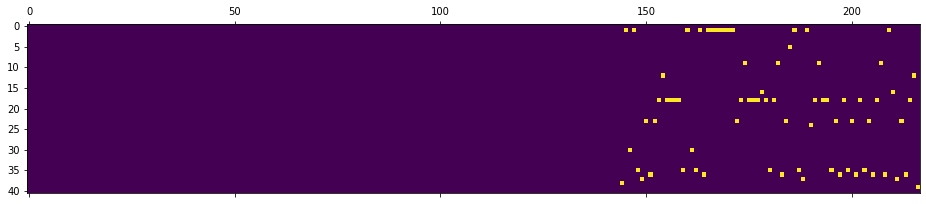

In [ ]:
### USANDO LA LIB molvecgen
mols_all = [Chem.MolFromSmiles(smile) for smile in X]
sm_train = SmilesVectorizer(canonical=True, augment=True, leftpad=True)
sm_test = SmilesVectorizer(canonical=True, augment=False, leftpad=True)
sm_train.fit(mols_all) #, extra_chars=['9'])  
sm_test.fit(mols_all) #, extra_chars=['9'])

#Paso de String a Mols
mols_train = [Chem.MolFromSmiles(smile) for smile in X_train]
mols_test = [Chem.MolFromSmiles(smile) for smile in X_test]

#Creo los Generators
generator = SmilesGenerator(mols_train,y_train,sm_train, batch_size=batch_size, shuffle=True)
generatorTest = SmilesGenerator(mols_test,y_test,sm_test, batch_size=batch_size, shuffle=True)

#Chequeo
batch_x, batch_y = generator.next()
print(batch_x.shape)
print(batch_y.shape)
print(batch_y)
plt.matshow(batch_x[0].T)

In [ ]:
### USANDO LA LIB SMILES-enumeration # La lib creo que tiene algunos issues, al final es mejor la molvecgen
  #sme = SmilesEnumerator()
  #smeTest = SmilesEnumerator(enum=False) 
  #sme.fit(df['canonical_smiles'])
  #smeTest.fit(df['canonical_smiles'])
#No aparece en vocabulario el caracter '9' cuando se hace el fit, por eso lo tengo que hacer manualmente 
  #sme._char_to_int.update({'9': 38})
  #sme._charlen=39
  #smeTest._char_to_int.update({'9': 38})
  #smeTest._charlen=39
## Ver porque no funciona "bien" la lib o si se puede hacer de otra forma.

  #sme.leftpad= True
  #smeTest.leftpad= True

  #generator = SmilesIterator(X_train, y_train, sme, batch_size=250, shuffle=True, dtype=K.floatx())
  #generatorTest = SmilesIterator(X_test, y_test, smeTest, batch_size=250, shuffle=False, dtype=K.floatx())

# Esto era cuando no me habia dado cuenta que el generator de la lib no tiene encuenta la cantidad de datos, y genera batchs infinitamente.
  #X_trainG,y_trainG = generator.next()
  #X_testG,y_testG = generatorTest.next()

  #print(X_train.shape, X_test.shape)
  #print(X_trainG.shape, X_testG.shape)
  #plt.imshow(X_trainG[1])


# INPUTS CON SMILES VECTORIZADOS CON DATA AUGMENTATION

In [ ]:
#Parametros - Hiper-parametros Generales
x_temp, y_temp = generator.next()
input_shape = x_temp.shape[1:]
output_shape = 1
train_step = round(y_train.shape[0]/batch_size)
validation_step = round(y_test.shape[0]/batch_size)
lstm_dropout = 0.19
l1 = 0.005
l2 = 0.01
learning_rate=0.005
cant_neuronas_lstm = 64
cant_neuronas_hidden_layer = 100

FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 64

## **PRUEBA-1** Smiles Vectorizados - LSTM
-Mejor R2 de Validacion logrado= 0.68

In [ ]:
# Modelo
model = Sequential()
model.add(LSTM(cant_neuronas_lstm,
               input_shape=input_shape,
               dropout = lstm_dropout
               #unroll= True
              ))
model.add(Dense(output_shape,
                kernel_regularizer=regularizers.l1_l2(l1,l2),
                activation="linear"))

model.compile(loss="mse", optimizer=RMSprop(learning_rate=learning_rate),  metrics=[R2])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64)                27136     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 27,201
Trainable params: 27,201
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()

In [ ]:
#model.fit(generator,  epochs=2000, validation_data=generatorTest, steps_per_epoch=20,  callbacks=[earlystop, mcp] )
model.fit(generator, validation_data=generatorTest, steps_per_epoch=train_step, validation_steps=validation_step , epochs=2000, callbacks=[earlystop] )

Epoch 1/2000
16/16 [==============================] - 10s 139ms/step - loss: 6.8594 - R2: -1.4462 - val_loss: 2.9740 - val_R2: -0.0064
Epoch 2/2000
16/16 [==============================] - 2s 106ms/step - loss: 2.9015 - R2: -0.0395 - val_loss: 3.1556 - val_R2: -0.0630
Epoch 3/2000
16/16 [==============================] - 2s 105ms/step - loss: 2.9458 - R2: -0.0315 - val_loss: 3.0846 - val_R2: -0.0413
Epoch 4/2000
16/16 [==============================] - 2s 107ms/step - loss: 2.9057 - R2: -0.0170 - val_loss: 2.9461 - val_R2: -7.6011e-04
Epoch 5/2000
16/16 [==============================] - 2s 106ms/step - loss: 2.9074 - R2: -0.0215 - val_loss: 2.9367 - val_R2: 0.0055
Epoch 6/2000
16/16 [==============================] - 2s 107ms/step - loss: 2.8658 - R2: -0.0181 - val_loss: 2.9023 - val_R2: 0.0170
Epoch 7/2000
16/16 [==============================] - 2s 111ms/step - loss: 2.9055 - R2: -7.9785e-04 - val_loss: 2.9696 - val_R2: 0.0018
Epoch 8/2000
16/16 [==============================] - 2s

In [ ]:
generatorTest = SmilesGenerator(mols_test,y_test,sm_test, batch_size=X_test.shape[0], shuffle=True)
test_x, test_y = generatorTest.next()
y_pred  = model.predict(test_x)

In [ ]:
y_pred.reshape(-1).shape


(1021,)

In [ ]:
R2_numpy(test_y, y_pred.reshape(-1))

0.6505620641463796

## **PRUEBA-2** Smiles Vectorizados - Bidirectional-LSTM

In [ ]:
# Modelo
#input_shape = X_testG.shape[1:]
model2 = Sequential()
model2.add(InputLayer(input_shape=input_shape))
model2.add(Bidirectional( LSTM(cant_neuronas_lstm,               
               dropout = lstm_dropout               
              )))
model2.add(Dense(cant_neuronas_hidden_layer))
model2.add(BatchNormalization())
model2.add( Activation('relu'))

model2.add(Dense(output_shape,
                kernel_regularizer=regularizers.l1_l2(0.005,0.01),
                activation="linear"))

model2.compile(loss="mse", optimizer=RMSprop(learning_rate=learning_rate),  metrics=[R2])
model2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 128)               54272     
_________________________________________________________________
dense_10 (Dense)             (None, 100)               12900     
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
activation_4 (Activation)    (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 101       
Total params: 67,673
Trainable params: 67,473
Non-trainable params: 200
_________________________________________________________________


In [ ]:
#model2.fit(X_trainG, y_trainG, validation_data=(X_testG, y_testG), epochs=2000, batch_size=250, callbacks=[earlystop] )
model2.fit(generator, validation_data=generatorTest, steps_per_epoch=train_step, validation_steps=validation_step , epochs=2000, callbacks=[earlystop] )

Epoch 1/2000
16/16 [==============================] - 8s 268ms/step - loss: 13.1042 - R2: -3.6627 - val_loss: 22.5565 - val_R2: -6.7814
Epoch 2/2000
16/16 [==============================] - 3s 194ms/step - loss: 3.7288 - R2: -0.2955 - val_loss: 18.7982 - val_R2: -5.4771
Epoch 3/2000
16/16 [==============================] - 3s 163ms/step - loss: 3.1738 - R2: -0.0998 - val_loss: 14.6009 - val_R2: -4.0236
Epoch 4/2000
16/16 [==============================] - 3s 194ms/step - loss: 2.6206 - R2: 0.0392 - val_loss: 14.2431 - val_R2: -3.9008
Epoch 5/2000
16/16 [==============================] - 3s 173ms/step - loss: 2.6312 - R2: 0.0907 - val_loss: 11.1288 - val_R2: -2.8242
Epoch 6/2000
16/16 [==============================] - 3s 174ms/step - loss: 2.6119 - R2: 0.1099 - val_loss: 12.7013 - val_R2: -3.3707
Epoch 7/2000
16/16 [==============================] - 3s 171ms/step - loss: 2.4660 - R2: 0.1244 - val_loss: 14.9311 - val_R2: -4.1445
Epoch 8/2000
16/16 [==============================] - 3s 1

## **PRUEBA-3** Smiles Vectorizados - CNN tipo Inception

-Mejor R2 de Validacion logrado= 0.65

In [ ]:
# Implementar modelo de TextCNN
def text_cnn_1d_sinEmbedding(sequence_length, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = Input(shape=sequence_length, name='input_x')
    #embedding_layer = Embedding(vocab_size+1, embedding_size, input_length=max_sequence_len)(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv1D = Conv1D( num_filters, filter_size, activation='relu', padding='same')(input_x)
        max_p = MaxPool1D()(conv1D)
        pooled_outputs.append(max_p)

    #h_pool = Concatenate()(pooled_outputs)    
    h_pool = Concatenate(axis=2)(pooled_outputs)
    h_pool = GlobalMaxPooling1D()(h_pool)  #Flatten porque tengo MaxPool1D en vez de GlobalMaxPooling1D?
    dense = Dense(cant_neuronas_hidden_layer, activation='relu')(h_pool)
    dense=Dropout(0.2)(dense)
    dense = Dense(cant_neuronas_hidden_layer-50, activation='relu')(dense)
    dense=Dropout(0.2)(dense)
    dense = Dense(1)(dense) # Salida
    model = Model(input_x, dense)
    return model

In [ ]:
model3 = text_cnn_1d_sinEmbedding(input_shape, FILTER_SIZES, NUM_FILTERS)
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 217, 41)]    0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 217, 64)      7936        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 217, 64)      10560       input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 217, 64)      13184       input_x[0][0]                    
____________________________________________________________________________________________

In [ ]:
model3.compile(loss="mse", optimizer=RMSprop(learning_rate=learning_rate),  metrics=[R2])
#model3.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=[R2])

In [ ]:
#model3.fit(X_trainG, y_trainG, validation_data=(X_testG, y_testG), epochs=2000, batch_size=128, callbacks=[earlystop, tensorboard_callback] )

model3.fit(generator, validation_data=generatorTest, steps_per_epoch=train_step, validation_steps=validation_step , epochs=2000, callbacks=[earlystop] )

Epoch 1/2000
16/16 [==============================] - 5s 344ms/step - loss: 0.5852 - R2: 0.7955 - val_loss: 1.0701 - val_R2: 0.6151
Epoch 2/2000
16/16 [==============================] - 5s 340ms/step - loss: 0.6843 - R2: 0.7434 - val_loss: 1.1169 - val_R2: 0.6157
Epoch 3/2000
16/16 [==============================] - 6s 349ms/step - loss: 0.6892 - R2: 0.7526 - val_loss: 0.9750 - val_R2: 0.6562
Epoch 4/2000
16/16 [==============================] - 6s 361ms/step - loss: 0.6762 - R2: 0.7531 - val_loss: 1.0430 - val_R2: 0.6346
Epoch 5/2000
16/16 [==============================] - 6s 361ms/step - loss: 0.6356 - R2: 0.7743 - val_loss: 1.2948 - val_R2: 0.5442
Epoch 6/2000
16/16 [==============================] - 6s 353ms/step - loss: 0.6530 - R2: 0.7635 - val_loss: 0.9667 - val_R2: 0.6543
Epoch 7/2000
16/16 [==============================] - 6s 351ms/step - loss: 0.6429 - R2: 0.7659 - val_loss: 0.9165 - val_R2: 0.6737
Epoch 8/2000
16/16 [==============================] - 6s 349ms/step - loss: 

In [ ]:
path+'fit_tensorboard/'


'/content/drive/MyDrive/TRABAJO/Data Science/ITBA-DeepLearning/Notebooks/TP-FINAL/bioinformatics_final_project/fit_tensorboard/'

In [ ]:
%load_ext tensorboard
%tensorboard --logdir log_dir=path+'fit_tensorboard/*'

# Utilizando de Input a Fingerprints

In [ ]:
!pip install pandas_summary
from pandas_summary import DataFrameSummary
from sklearn.preprocessing import LabelEncoder, StandardScaler

## Carga de Datos

In [ ]:
df_completo = pd.read_csv(path+'data/acetylcholinesterase_02_bioactivity_data_preprocessed_token_descriptors.csv')
X= df_completo.drop(['molecule_chembl_id', 'canonical_smiles', 'standard_value',
       'standard_value_norm', 'pIC50', 'X_seq', 'X_seq_pad', 'MW', 'LogP',
       'NumHDonors', 'NumHAcceptors', 'bioactivity_class', 'Name'], axis=1)
y = df_completo.pIC50.values

Los features de fingerprints son booleanos, lo normalizamos aunque tambien se puede utilizarlos como vienen

In [ ]:
normalizar_features = False
if normalizar_features:
  from sklearn_pandas import DataFrameMapper
  contin_maps = [([o], StandardScaler()) for o in X.columns.values]
  mapper_cont = DataFrameMapper(contin_maps)
  X[X.columns.values] = mapper_cont.fit_transform(X)



In [ ]:
summary = DataFrameSummary(X).summary().loc[['uniques', 'types', 'missing']]
summary

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
uniques,2,2,2,2,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,1,2,1,2,2,1,2,2,1,1,2,2,2,...,2,2,2,1,2,1,2,1,1,1,2,1,1,2,1,1,1,1,1,2,2,2,2,2,1,2,1,2,1,1,1,2,1,1,2,1,1,1,1,1
types,bool,bool,bool,bool,constant,constant,constant,constant,constant,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,constant,constant,bool,constant,bool,bool,constant,bool,bool,constant,constant,bool,bool,bool,...,bool,bool,bool,constant,bool,constant,bool,constant,constant,constant,bool,constant,constant,bool,constant,constant,constant,constant,constant,bool,bool,bool,bool,bool,constant,bool,constant,bool,constant,constant,constant,bool,constant,constant,bool,constant,constant,constant,constant,constant
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Tienen muchos features que siempre estan en cero, presentamos dos formas de depuraralos:
1. Solo nos quedamos con las que son binarias y presentan valores 0 o 1


In [ ]:
b = summary.T
boolean = b[b.uniques==2]
colbool = boolean.T
X=X[colbool.columns.values]
X.shape

(5103, 634)

2. Otra opción es quedarnos con las que tienen un varianza alta

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X_variance = selection.fit_transform(X)
print(X_variance.shape, X.shape) # Reduccion de 881 a 140 features (elimino 741 features de baja varianza)
X=X_variance

(5103, 140) (5103, 634)


## Split de Datos

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2,random_state=42)


## Hiper - Parametros 

In [ ]:
 X.shape[1:]

(140,)

In [ ]:
#Parametros - Hiper-parametros Generales
#x_temp, y_temp = generator.next()
batch_size = 250
input_shape = X.shape[1]
output_shape = 1
train_step = round(y_train.shape[0]/batch_size)
validation_step = round(y_val.shape[0]/batch_size)
lstm_dropout = 0.19
reg_l1 = 0.005
reg_l2 = 0.01
learning_rate=0.01
cant_neuronas_lstm = 64
cant_neuronas_hidden_layer = 100

FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 64


first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 1e-3

In [ ]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=2)

### MLP con FingerPrints

In [ ]:
# Modelo
model = Sequential()
model.add(Dense(25, input_shape=(input_shape,) ))
model.add(BatchNormalization())
model.add(Activation('linear'))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(50))##, kernel_regularizer=l2(l2_lambda)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(output_shape,
                kernel_regularizer=regularizers.l1_l2(reg_l1,reg_l2),
                activation="linear"))

model.compile(loss="mse", optimizer=RMSprop(learning_rate=learning_rate),  metrics=[R2])
model.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_94 (Dense)             (None, 25)                3525      
_________________________________________________________________
batch_normalization_16 (Batc (None, 25)                100       
_________________________________________________________________
activation_34 (Activation)   (None, 25)                0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 25)                0         
_________________________________________________________________
dense_95 (Dense)             (None, 50)                1300      
_________________________________________________________________
batch_normalization_17 (Batc (None, 50)                200       
_________________________________________________________________
activation_35 (Activation)   (None, 50)              

In [ ]:
model.compile(loss="mse", optimizer=RMSprop(learning_rate=learning_rate),  metrics=[R2])
model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=2000, callbacks=[earlystop] )

Epoch 1/2000
17/17 [==============================] - 2s 19ms/step - loss: 7.9884 - R2: -1.8041 - val_loss: 14.0260 - val_R2: -4.7029
Epoch 2/2000
17/17 [==============================] - 0s 6ms/step - loss: 3.4483 - R2: -0.2198 - val_loss: 22.6698 - val_R2: -8.1498
Epoch 3/2000
17/17 [==============================] - 0s 6ms/step - loss: 3.3130 - R2: -0.1640 - val_loss: 5.1045 - val_R2: -0.9472
Epoch 4/2000
17/17 [==============================] - 0s 6ms/step - loss: 3.1934 - R2: -0.1380 - val_loss: 5.9272 - val_R2: -1.3514
Epoch 5/2000
17/17 [==============================] - 0s 6ms/step - loss: 3.0412 - R2: -0.0721 - val_loss: 8.3366 - val_R2: -2.5002
Epoch 6/2000
17/17 [==============================] - 0s 7ms/step - loss: 2.9698 - R2: -0.0450 - val_loss: 4.2617 - val_R2: -0.5833
Epoch 7/2000
17/17 [==============================] - 0s 6ms/step - loss: 2.9339 - R2: -0.0351 - val_loss: 5.4106 - val_R2: -1.1898
Epoch 8/2000
17/17 [==============================] - 0s 6ms/step - loss:

In [ ]:
X.head()

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,PubchemFP10,PubchemFP11,PubchemFP12,PubchemFP13,PubchemFP14,PubchemFP15,PubchemFP16,PubchemFP17,PubchemFP18,PubchemFP19,PubchemFP20,PubchemFP21,PubchemFP22,PubchemFP23,PubchemFP24,PubchemFP25,PubchemFP26,PubchemFP27,PubchemFP28,PubchemFP29,PubchemFP30,PubchemFP31,PubchemFP32,PubchemFP33,PubchemFP34,PubchemFP35,PubchemFP36,PubchemFP37,PubchemFP38,PubchemFP39,...,PubchemFP841,PubchemFP842,PubchemFP843,PubchemFP844,PubchemFP845,PubchemFP846,PubchemFP847,PubchemFP848,PubchemFP849,PubchemFP850,PubchemFP851,PubchemFP852,PubchemFP853,PubchemFP854,PubchemFP855,PubchemFP856,PubchemFP857,PubchemFP858,PubchemFP859,PubchemFP860,PubchemFP861,PubchemFP862,PubchemFP863,PubchemFP864,PubchemFP865,PubchemFP866,PubchemFP867,PubchemFP868,PubchemFP869,PubchemFP870,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,0,0,0,0,0,0,1,1,1,1,0,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Utilizando Embeddings

In [ ]:
import os.path

if not os.path.isfile('001_Data_retrieve.ipynb'):
    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)
    downloaded = drive.CreateFile({'id':'10fMCM9wnmjlyGwiyNzpfPROExiq8ukKk'})
    downloaded.GetContentFile('dataaug.py')
    downloaded = drive.CreateFile({'id':'1jPB1HDpGN5zFRuhqN6b9RLMuuUQy0UoB'})
    downloaded.GetContentFile('datagen.py')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datagen import smiles_dict, smiles_to_seq, DataGenerator
from dataaug import SmilesEnumerator

### Carga de Datos y seleccion de features y outputs

In [ ]:
df_completo = pd.read_csv(path+'data/acetylcholinesterase_02_bioactivity_data_preprocessed_token_descriptors.csv')

max_len_idx = df_completo['canonical_smiles'].apply(len).argmax()
max_sequence_len = len(df_completo['canonical_smiles'].iloc[max_len_idx]) + 20

X = df_completo['canonical_smiles'].values
y = df_completo['pIC50'].values



###SPLIT DE DATOS y GENERATORS

In [ ]:
batch_size = 250

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=batch_size, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=batch_size, data_augmentation=False)

for i, (X_b, y_b) in enumerate(dgen_train):
  print(X_b.shape, y_b.shape)
  break

(4082, 227) (4082,)


## TextCNN similar a la de deepchem

In [ ]:
# Implementar modelo de TextCNN
def text_cnn_1d(sequence_length, vocab_size, embedding_size, filter_sizes, num_filters):
    # Recordar que estamos en la funcional model API y hay que entender que conectar con que.
    input_x = Input(shape=(sequence_length,), name='input_x')
                          # cant caracteres unicos, #long vect Emb,  #max vocabulario     
    embedding_layer = Embedding(vocab_size+1, embedding_size, input_length=sequence_length  )(input_x)
    pooled_outputs = []
    for filter_size in filter_sizes:
        conv1D = Conv1D( num_filters, filter_size, padding='valid')(embedding_layer) #sin activacion !!
        max_p = GlobalMaxPooling1D()(conv1D)
        pooled_outputs.append(max_p)
        
    h_pool = Concatenate(axis=1)(pooled_outputs)
    ##h_pool = Flatten()(h_pool)  #Flatten porque tengo MaxPool1D en vez de GlobalMaxPooling1D?
    h_pool = Dropout(0.1)(h_pool)
    dense = Dense(200, activation='relu')(h_pool)
    
    #dense = Dense(50, activation='relu')(dense)
    dense = Dense(1)(dense) # Salida
    model = Model(input_x, dense)
    return model

In [ ]:
len(smiles_dict)+1

43

In [ ]:

FILTER_SIZES = (3, 4, 5)
NUM_FILTERS = 128
vocab_size = len(smiles_dict)+1
embeddings_size = 128 # 2
learning_rate = 0.001

In [ ]:
model = text_cnn_1d(max_sequence_len, vocab_size, embeddings_size, FILTER_SIZES, NUM_FILTERS)
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_x (InputLayer)            [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 227, 128)     5632        input_x[0][0]                    
__________________________________________________________________________________________________
conv1d_13 (Conv1D)              (None, 225, 128)     49280       embedding_18[0][0]               
__________________________________________________________________________________________________
conv1d_14 (Conv1D)              (None, 224, 128)     65664       embedding_18[0][0]               
___________________________________________________________________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[R2])
history = model.fit(dgen_train, epochs=2000, validation_data=dgen_test, callbacks=[earlystop])

Epoch 1/2000
17/17 [==============================] - 58s 1s/step - loss: 14.1173 - R2: -4.0675 - val_loss: 4.1901 - val_R2: -0.4516
Epoch 2/2000
17/17 [==============================] - 24s 1s/step - loss: 3.1212 - R2: -0.1204 - val_loss: 2.6510 - val_R2: 0.0816
Epoch 3/2000
17/17 [==============================] - 24s 1s/step - loss: 2.5712 - R2: 0.0770 - val_loss: 2.4168 - val_R2: 0.1627
Epoch 4/2000
17/17 [==============================] - 25s 1s/step - loss: 2.3397 - R2: 0.1601 - val_loss: 2.3064 - val_R2: 0.2010
Epoch 5/2000
17/17 [==============================] - 24s 1s/step - loss: 2.2574 - R2: 0.1897 - val_loss: 2.2235 - val_R2: 0.2297
Epoch 6/2000
17/17 [==============================] - 24s 1s/step - loss: 2.2029 - R2: 0.2093 - val_loss: 2.1679 - val_R2: 0.2489
Epoch 7/2000
17/17 [==============================] - 24s 1s/step - loss: 2.1501 - R2: 0.2282 - val_loss: 2.1169 - val_R2: 0.2666
Epoch 8/2000
17/17 [==============================] - 25s 1s/step - loss: 2.1008 - R2:

KeyboardInterrupt: ignored

# TSNE de Embeddings

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import sklearn as sk
from matplotlib import pyplot as plt

## Embeddings 

In [ ]:
##Parametros
k_vecinos = 5
n_pad = 0
reverse_smiles_dict = dict([(value, key) for (key, value) in smiles_dict.items()]) 

In [ ]:
cargar_embeddings = False
grabar_embeddings = True

if cargar_embeddings:
  embeddings = np.load(path+'data/embeddings_textcnn.npy')
else:
  #Obtengo los embeddings
  embeddings = model.layers[1].get_weights()[0] #obtengo los pesos de la primera capa, luego como es un lista de arrays, la paso a array haciendo list[0]
print('embeddings shape',embeddings.shape)

#Si quiero grabar el embedding 
if grabar_embeddings:
  np.save(path+'data/embeddings_textcnn', embeddings)

#Obtener los 5 caracteres (atomos) mas cercanos segun distancia coseno
nearest = sk.neighbors.NearestNeighbors(k_vecinos, metric='cosine')
nearest.fit(embeddings)


embeddings shape (44, 128)


NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [ ]:
def get_nearest_words(nearest, embeddings, char, index, reverse_index, n_pad = 0):
  distances, nearest_indexes = nearest.kneighbors(embeddings[index[char]+n_pad].reshape(1,-1))  # Finds the K-neighbors of a point.
  lista_de_char = []
  for idx, d in zip(nearest_indexes[0], distances[0]):
    # Recordar restar el padding al reverse_index: reverse_index[idx-n_pad]
    lista_de_char.append(reverse_index[idx-n_pad])
  return lista_de_char


In [ ]:
print('5 moleculas mas similares a "c" con respecto a pIC50 son:' ,get_nearest_words(nearest, embeddings, 'c', smiles_dict, reverse_smiles_dict))
print('5 moleculas mas similares a "#" con respecto a pIC50 son:' ,get_nearest_words(nearest, embeddings, '#', smiles_dict, reverse_smiles_dict))

5 moleculas mas similares a "c" con respecto a pIC50 son: ['c', '4', 'n', '6', '1']
5 moleculas mas similares a "#" con respecto a pIC50 son: ['#', 'S', '4', 's', 'c']


## TSNE

In [ ]:
tsne = TSNE(2, verbose=1)
tsn_2d_emb = tsne.fit_transform(embeddings)


[t-SNE] Computing 43 nearest neighbors...
[t-SNE] Indexed 44 samples in 0.000s...
[t-SNE] Computed neighbors for 44 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 44 / 44
[t-SNE] Mean sigma: 0.639239
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.584404
[t-SNE] KL divergence after 1000 iterations: 0.467138


### INTERPRETACION DE TSNET (al menos lo trate :) )
Analizo si hay algunos chars caracteristicos bio_actividad alta o baja, ya que las predicciones que realiza el modelo son los pic50, una escala log. de standar_value, el cual se utiliza para clasificar como Activo --> standar_value >= 10000 e Inactivo Inactivos <1000 

In [ ]:
# Activos standar_value >= 10000   Inactivos <1000 y el 'pic50' es una escala log. del  standar_value -->df['standard_value'].apply(lambda x: -np.log10(x*(10**-9)))
df_active =  df_completo[df_completo.bioactivity_class=='active']
smiles_active_concat = df_active.canonical_smiles.str.cat()

count_active = {}
for s in smiles_active_concat:
  if s in count_active:
    count_active[s] += 1
  else:
    count_active[s] = 1

print('char mas activos:',{k: v for k, v in sorted(count_active.items(), key=lambda item: item[1], reverse=True)})
char_active = ['c', 'C', '(', ')', '1', 'O', '2', 'N','3', '=' ]


df_inactive =  df_completo[df_completo.bioactivity_class=='inactive']
smiles_inactive_concat = df_inactive.canonical_smiles.str.cat()

count_inactive = {}
for s in smiles_inactive_concat:
  if s in count_inactive:
    count_inactive[s] += 1
  else:
    count_inactive[s] = 1

print('char mas inactivos:',{k: v for k, v in sorted(count_inactive.items(), key=lambda item: item[1], reverse=True)})
char_active = ['c', 'C', '(', ')', '1', 'O', '2', 'N','3', '=' ]


char mas activos: {'c': 30335, 'C': 27390, '(': 9352, ')': 9352, '1': 6744, 'O': 5316, '2': 5250, 'N': 4415, '3': 3488, '=': 3395, '[': 2036, ']': 2036, 'n': 1840, '4': 1708, '@': 1294, 'H': 785, 'l': 740, '-': 720, '.': 601, '5': 588, '+': 504, 'o': 397, '/': 368, 'F': 340, 'S': 260, 'B': 258, 'r': 258, '6': 188, 's': 112, '#': 108, '\\': 70, 'I': 29, '7': 10, 'e': 10, 'P': 4, '8': 4, 'i': 2, 'a': 1}
char mas inactivos: {'c': 18177, 'C': 16437, '(': 6546, ')': 6546, '1': 4558, 'O': 4096, '2': 3506, 'N': 2551, '=': 2423, '[': 2253, ']': 2253, '@': 2060, '3': 1967, 'n': 1182, 'H': 1030, '4': 720, '/': 689, '-': 652, 'F': 443, '.': 420, '+': 407, 'l': 399, 'B': 227, 'r': 204, 'S': 165, 'o': 163, '\\': 161, '5': 138, '#': 107, 's': 38, 'I': 35, 'P': 17, 'e': 7, '6': 6, '7': 2}


In [ ]:
set_activos = set(list(count_active.keys()))
set_inactivos = set(count_inactive.keys())
dist = set_activos.symmetric_difference(set_inactivos)
dist

{'8', 'a', 'i'}

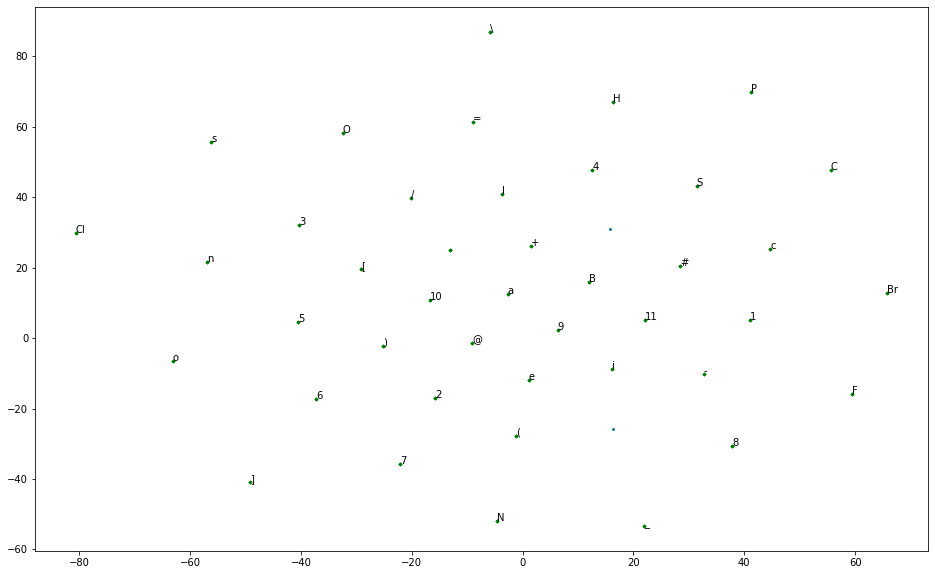

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(tsn_2d_emb[:,0], tsn_2d_emb[:,1], s=4)
for char in smiles_dict:
  plt.scatter(tsn_2d_emb[smiles_dict[char]+n_pad][0], tsn_2d_emb[smiles_dict[char]+n_pad][1], c='g', s=5, marker='D')
  plt.text(tsn_2d_emb[smiles_dict[char]+n_pad][0], tsn_2d_emb[smiles_dict[char]+n_pad][1], char, rotation='horizontal')

In [ ]:
smiles_dict

{'#': 1,
 '(': 2,
 ')': 3,
 '+': 43,
 '-': 5,
 '.': 35,
 '/': 6,
 '1': 7,
 '10': 41,
 '11': 42,
 '2': 8,
 '3': 9,
 '4': 10,
 '5': 11,
 '6': 12,
 '7': 13,
 '8': 14,
 '9': 40,
 '=': 15,
 '@': 34,
 'B': 37,
 'Br': 30,
 'C': 16,
 'Cl': 29,
 'F': 17,
 'H': 18,
 'I': 19,
 'N': 20,
 'O': 21,
 'P': 22,
 'S': 23,
 '[': 24,
 '\\': 25,
 ']': 26,
 '_': 27,
 'a': 36,
 'c': 28,
 'e': 38,
 'i': 39,
 'n': 31,
 'o': 32,
 's': 33}

# ATTENTION

## Cargar los Datos y Split

In [ ]:
df_completo = pd.read_csv(path+'data/acetylcholinesterase_02_bioactivity_data_preprocessed_token_descriptors.csv')

max_len_idx = df_completo['canonical_smiles'].apply(len).argmax()
max_sequence_len = len(df_completo['canonical_smiles'].iloc[max_len_idx]) + 20

X = df_completo['canonical_smiles'].values
y = df_completo['pIC50'].values

batch_size = 250

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
dgen_train = DataGenerator(X_train, y_train, seq_length=max_sequence_len, batch_size=batch_size, data_augmentation=True)
dgen_test = DataGenerator(X_test, y_test, seq_length=max_sequence_len, batch_size=batch_size, data_augmentation=False)

for i, (X_b, y_b) in enumerate(dgen_train):
  print(X_b.shape, y_b.shape)
  break

(4082, 227) (4082,)


## MODELO: MLP + EMBEDDINGS + ATTENTION

In [ ]:
##Parametros
vocab_size = len(smiles_dict)+1
embeddings_size = 128 # 2
learning_rate = 0.01
embeddings_matrix = np.load(path+'data/embeddings_textcnn.npy')
key_dim=50


#nb_words=num_words
num_filters=64

In [ ]:
def softMaxOverTime(x):
    return softmax(x,axis=1)

input_layer = Input(shape=(max_sequence_len,)) #input de dimension (None,500)
embedding_layer=Embedding(vocab_size+1, embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=max_sequence_len, trainable=False)(input_layer)

#key_dim: Difine la long del vector de key o value, es cant de neurona de la densa, y tambien la cantidad de salida de ese capa.
dense_input=Dense(key_dim,activation="relu")(embedding_layer) #SALIDA KEYS, es para reducir la dimension
ulog_attention=Dense(1,activation="linear")(dense_input)#SALIDA SCORE, es de UNA neurona porque la Q que hago es si el compuesto es Activo o Inactivo !!! ???
attention=Activation(softMaxOverTime)(ulog_attention)#SALIDA ALFAS

#Ahora tengo que multiplicar los alfas con cada Vector Embedding y luego sumarlo para obtener un vector de long 300
repeated_attention=TimeDistributed(RepeatVector(embeddings_matrix.shape[1]))(attention)
repeated_attention=Reshape([max_sequence_len,embeddings_matrix.shape[1]])(repeated_attention) # aplico reshape para None,500,300,1 --> None,500,300
weighted_embeddings=Multiply()([repeated_attention,embedding_layer]) #multiplico (ver imagen)
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)# sumo

#tengo un embedding ponderador el cual le paso a la MLP como siempre
dense1=Dense(200, activation='relu')(embedding_sum)
dense1=Dense(50, activation='relu')(dense1)
dense2=Dense(1)(dense1)

model=Model(input_layer , dense2)

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 227, 128)     5632        input_11[0][0]                   
__________________________________________________________________________________________________
dense_26 (Dense)                (None, 227, 50)      6450        embedding_9[0][0]                
__________________________________________________________________________________________________
dense_27 (Dense)                (None, 227, 1)       51          dense_26[0][0]                   
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[R2])
history = model.fit(dgen_train, epochs=2000, validation_data=dgen_test, callbacks=[earlystop])

Epoch 1/2000
17/17 [==============================] - 19s 1s/step - loss: 12.6991 - R2: -3.5584 - val_loss: 5.3979 - val_R2: -0.8701
Epoch 2/2000
17/17 [==============================] - 18s 1s/step - loss: 3.7960 - R2: -0.3626 - val_loss: 3.1426 - val_R2: -0.0887
Epoch 3/2000
17/17 [==============================] - 18s 1s/step - loss: 3.0239 - R2: -0.0854 - val_loss: 2.9790 - val_R2: -0.0321
Epoch 4/2000
17/17 [==============================] - 18s 1s/step - loss: 2.8620 - R2: -0.0273 - val_loss: 2.9538 - val_R2: -0.0233
Epoch 5/2000
17/17 [==============================] - 18s 1s/step - loss: 2.7581 - R2: 0.0099 - val_loss: 3.0046 - val_R2: -0.0409
Epoch 6/2000
17/17 [==============================] - 18s 1s/step - loss: 2.6880 - R2: 0.0351 - val_loss: 3.0511 - val_R2: -0.0570
Epoch 7/2000
17/17 [==============================] - 18s 1s/step - loss: 2.5963 - R2: 0.0681 - val_loss: 2.9847 - val_R2: -0.0340
Epoch 8/2000
17/17 [==============================] - 18s 1s/step - loss: 2.38

KeyboardInterrupt: ignored

## MODELO: MLP + EMBEDDINGS + ATTENTION + ContextCNN

In [ ]:
#parametros

value_dim=100
learning_rate= 0.01


In [ ]:
def softMaxOverTime(x):
    return softmax(x,axis=1)

input_layer = Input(shape=(max_sequence_len,)) #input de dimension (None,500)
embedding_layer=Embedding(vocab_size+1, embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=max_sequence_len, trainable=False)(input_layer)



conv_out=Conv1D(value_dim,10,padding="same", activation='relu', name='CONV1')(embedding_layer)
    #conv_out=Activation("relu")(conv_out)
#conv_out=Conv1D(embeddings_matrix.shape[1],3,activation="relu",padding="same")(conv_out)
conv_out=Conv1D(embeddings_matrix.shape[1],5,activation="tanh",padding="same", name='convTANH')(conv_out) #SALIDA KEYS
#FIN PARTE DISTINTA


ulog_attention=Dense(1,activation="linear", name='DOT')(conv_out)#SALIDA SCORE, es de UNA neurona porque la Q que hago es si el compuesto es Activo o Inactivo !!! ???
attention=Activation(softMaxOverTime, name='SOFTMAX')(ulog_attention)#SALIDA ALFAS

#Ahora tengo que multiplicar los alfas con cada Vector Embedding y luego sumarlo para obtener un vector de long 300
repeated_attention=TimeDistributed(RepeatVector(embeddings_matrix.shape[1]))(attention)
repeated_attention=Reshape([max_sequence_len,embeddings_matrix.shape[1]])(repeated_attention) # aplico reshape para None,500,300,1 --> None,500,300
weighted_embeddings=Multiply()([repeated_attention,embedding_layer]) #multiplico (ver imagen)
embedding_sum = Lambda(lambda x: K.sum(x, axis=1))(weighted_embeddings)# sumo

#tengo un embedding ponderador el cual le paso a la MLP como siempre
dense1=Dense(200, activation='relu')(embedding_sum)
dense1=Dense(50, activation='relu')(dense1)
dense2=Dense(1)(dense1)

model_attention_contectCNN=Model(input_layer , dense2)

model_attention_contectCNN.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_49 (InputLayer)           [(None, 227)]        0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 227, 128)     5632        input_49[0][0]                   
__________________________________________________________________________________________________
CONV1 (Conv1D)                  (None, 227, 100)     128100      embedding_48[0][0]               
__________________________________________________________________________________________________
convTANH (Conv1D)               (None, 227, 128)     64128       CONV1[0][0]                      
___________________________________________________________________________________________

In [ ]:
model_attention_contectCNN.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=[R2])
history = model_attention_contectCNN.fit(dgen_train, epochs=2000, validation_data=dgen_test, callbacks=[earlystop])

Epoch 1/2000
17/17 [==============================] - 24s 1s/step - loss: 10.3323 - R2: -2.7089 - val_loss: 3.4662 - val_R2: -0.2008
Epoch 2/2000
17/17 [==============================] - 22s 1s/step - loss: 3.2419 - R2: -0.1637 - val_loss: 2.8883 - val_R2: -6.1893e-04
Epoch 3/2000
17/17 [==============================] - 22s 1s/step - loss: 2.8736 - R2: -0.0315 - val_loss: 2.9472 - val_R2: -0.0210
Epoch 4/2000
17/17 [==============================] - 22s 1s/step - loss: 2.8060 - R2: -0.0073 - val_loss: 2.8892 - val_R2: -9.4140e-04
Epoch 5/2000
17/17 [==============================] - 22s 1s/step - loss: 2.7885 - R2: -9.6130e-04 - val_loss: 2.8879 - val_R2: -4.9841e-04
Epoch 6/2000
17/17 [==============================] - 22s 1s/step - loss: 2.7864 - R2: -2.0123e-04 - val_loss: 2.8872 - val_R2: -2.3878e-04
Epoch 7/2000
17/17 [==============================] - 22s 1s/step - loss: 2.7859 - R2: -3.7895e-05 - val_loss: 2.8865 - val_R2: -1.1921e-06
Epoch 8/2000
17/17 [=======================

KeyboardInterrupt: ignored